# Fun with FUN

This is the main companion notebook of the paper *Fun with FUN*.

## Setup

We assume you have executed the notebook ``data_preparation.ipynb`` to produce a file ``xgismo_fun.pkl.gz``. If it not the case and you want to execute this notebook, please start with the other notebook!

### Loading xgismo+spacy

If needed, adjust ``data_folder`` to point to the location of your ``funs_xgismo.pkl.gz`` file.

In [2]:
from pathlib import Path
data_folder = Path("../../../../../Datasets")
data_folder.exists()

True

Load the xgismo.

In [4]:
from gismo.gismo import XGismo
xgismo = XGismo(filename="xgismo_fun", path=data_folder)

That xgismo relies on spacy and its save does not embed the spacy NLP engine, so we need to load it separately.

In [5]:
import spacy
# Initialize spacy 'en' model, keeping only tagger component needed for lemmatization
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
keep = {'ADJ', 'NOUN', 'NUM', 'PROPN', 'SYM', 'VERB'}

Quick test, with the request *coloring*

In [6]:
xgismo.rank("coloring")

True

Associated vocabulary.

In [7]:
", ".join(xgismo.get_features_by_rank())

'color, coloring, edge, vertex, number, image, path, planar, free, color graph, maximum, minimum, edge color, parameterized, point, cover, trees, color problem, problems, matching, bound'

Associated authors

In [8]:
", ".join(xgismo.get_documents_by_rank()).replace('_', ' ')

'Balázs Keszegh, Magnús M. Halldórsson, Maria Chudnovsky, Mingxian Zhong, Petr A. Golovach, Fabian Kuhn, Marco Querini, Daniël Paulusma, Subhas C. Nandy, Giuseppe F. Italiano, Dániel Marx, Michael Lampis, Ken-ichi Kawarabayashi, Bartosz Walczak, Sang Won Bae, Dorothea Baumeister, Florian Sikora, Eyal Ackerman, Takao Nishizeki, Venkatesan Guruswami, Ankush Acharyya, Mario Valencia-Pabon, Girish Varma, Guillaume Fertin, Yakov Nekrich, Geir Agnarsson, Riccardo Dondi, Stefano Brocchi, Uri Zwick, Matias Korman, Sophie Spirkl, Dominique de Werra, Jörg Rothe, Sai Sandeep, Jian Song 0005, Alexandre Nolin, Roberto De Prisco, Meirav Zehavi, Aditi Majumder, Victor A. Campos'

### loading and formating FUN program committes and authors

We load the provided data.

In [9]:
import json
with open('fun_pcs.json', 'rt', encoding='utf8') as f:
    fun_pcs = json.load(f)
fun_pcs.keys()

dict_keys(['by_year', 'pcs'])

In [10]:
fun_pcs['by_year'].keys()

dict_keys(['1998', '2001', '2004', '2007', '2010', '2012', '2014', '2016', '2018', '2020', '2022'])

In [11]:
import json
with open('fun_authors.json', 'rt', encoding='utf8') as f:
    fun_authors = json.load(f)
fun_authors = {k: fun_authors[k] for k in sorted(fun_authors)}
fun_authors.keys()

dict_keys(['1998', '2002', '2004', '2007', '2010', '2012', '2014', '2016', '2018', '2021'])

We re-arrange slighly the content of the lists to make it easier to process afterwards. In details, we flatten the content into a corpus (list of dict), each dict having a display name (`name`) and a usable content (`dblp`).

In [12]:
pcs_source = [{'name': k, 'dblp': " ".join(v)} for k, v in fun_pcs['by_year'].items()]

In [13]:
authors_source = [{'name': k, 'dblp': " ".join(v)} for k, v in fun_authors.items()]

Last step: train the corpus. Each entry will be associated by the xgismo engine to a vector of authors and a vector of vocabulary. In Gismo terms, the association of a corpus of items to a double-vector representation is called *landmarks*.

Luckily, the creation of *landmarks* is fully implemented by gismo.

In [14]:
from gismo.landmarks import Landmarks
pcs_lmks = Landmarks(source=pcs_source, to_text=lambda x: x['dblp'],
                           rank = lambda g, q: g.rank(q, y=False))
pcs_lmks.fit(xgismo)

In [15]:
from gismo.landmarks import Landmarks
authors_lmks = Landmarks(source=authors_source, to_text=lambda x: x['dblp'],
                           rank = lambda g, q: g.rank(q, y=False))
authors_lmks.fit(xgismo)

A few tests: which committees were more adapted to coloring? (``max_k`` and ``target_k`` are hyper-parameters to adjust the number of results returned).

In [16]:
xgismo.rank("coloring")
pcs_lmks.post_item = lambda l, i: l[i]['name']
pcs_lmks.get_landmarks_by_rank(xgismo, target_k=1.1, max_k=10)

['2022', '2016', '2018']

What about authors?

In [17]:
authors_lmks.post_item = lambda l, i: l[i]['name']
authors_lmks.get_landmarks_by_rank(xgismo, target_k=1.1, max_k=10)

['2014', '2012']

What about NP-hardness?

In [18]:
xgismo.rank("NP-hard")
pcs_lmks.get_landmarks_by_rank(xgismo, target_k=1.1, max_k=10)

['2022', '2018']

In [19]:
authors_lmks.get_landmarks_by_rank(xgismo, target_k=1.1, max_k=10)

['2018', '2007', '2016']

Games?

In [20]:
xgismo.rank("Games")
pcs_lmks.get_landmarks_by_rank(xgismo, target_k=1.1, max_k=10)

['2018', '2012']

In [21]:
authors_lmks.get_landmarks_by_rank(xgismo, target_k=1.1, max_k=10)

['2010']

OK, things seem to be working (well it is hard to tell if it actually mean something at this point, we just mean that there is no obvious bug). We can start the actual study.

## Relationships across the years

Here, we propose to analyze how similar the committees and authors are with each others along the editions.

We will compute similarity using *cosine similarity* and display the results in a 2-dimensional *heatmap*. The following cell defines a class function for this purpose (and other things).

In [25]:
from matplotlib import pyplot as plt
import numpy as np

from sklearn.metrics.pairwise import cosine_similarity

def ticker(lmks, slc=None, get_name=None):
    if slc is None:
        slc = slice(len(lmks))
    if get_name is None:
        get_name = lambda l: l
    ticks = np.arange(len(lmks))[slc]
    tick_labels = [get_name(a) for a in lmks[slc]]
    return ticks, tick_labels



class HeatMap:
    """
    Class to display a heatmap that analyzes one or two landmarks.
    
    Parameters
    ----------
    x_lmks: Landmarks
        Landmarks for axis x.
    x_slice: slice, optional
        Subset of ticks to return for axis x.
    x_name: func, optional
        Callback to extract tick label from x_lmks.
    y_lmks: Landmarks, optional
        Landmarks for axis y. If None, x_lmks will be used as y_lmks as well (self-analysis).
    y_slice: slice, optional
        Subset of ticks to return for axis y.
    y_name: func, optional
        Callback to extract tick label from y_lmks.
    balance: float, optional
        Author / vocabulary trade-off in the dual embedding.
    y_key: func, optional
        if set, will be applied to the similarity matrix to produce `len(y_lmks)` values. 
        These values will be used to re-order the Y entries.
    vmin: float, optional
        Lower bound for the heatmap
    vmax: float, optional
        Upper bound for the heatmap
    """
    def __init__(self, x_lmks, x_slice=None, x_name=None,
                 y_lmks=None, y_slice=None, y_name=None,
                 balance=.5, y_key=None,
                 vmin=None, vmax=None):
        self.x_lmks = x_lmks
        self.x_slice = x_slice
        self.x_name = x_name
        if y_lmks is None:
            y_lmks = x_lmks
            y_slice = x_slice
            y_name = x_name
        self.y_lmks = y_lmks
        self.y_slice = y_slice
        self.y_name = y_name
        self.balance = balance
        self.y_key = y_key
        self.vmin = vmin
        self.vmax = vmax
        self.matrix = None
        
    def make_ticks(self):
        x_ticks, x_ticks_label = ticker(self.x_lmks, self.x_slice, self.x_name)
        y_ticks, y_ticks_label = ticker(self.y_lmks, self.y_slice, self.y_name)
        return x_ticks, x_ticks_label, y_ticks, y_ticks_label
    
    def compute_similarity(self):
        # LICO! y first for lines
        self.matrix = cosine_similarity(self.y_lmks.get_base(balance=.5),
                                        self.x_lmks.get_base(balance=.5))
        
    def compute_overlap(self, make_set=None):
        if make_set is None:
            make_set = lambda x: set(x['dblp'].split())
        overlap = np.zeros([len(self.y_lmks.source), len(self.x_lmks.source)])
        y_sets = [make_set(e) for e in self.y_lmks.source]
        x_sets = [make_set(e) for e in self.x_lmks.source]
        # LICO! y first for lines
        for i, p1 in enumerate(y_sets):
            for j, p2 in enumerate(x_sets):
                overlap[i, j] = (len(p1.intersection(p2)))/min(len(p1), len(p2))
        self.matrix = overlap
        
    def show(self, tikz=None):
        """
        Displays the heatmap.

        Parameters
        ----------

        tikz: str, optional
            If set, will save the plot in pgfplots format with the assigned name (requires tikzplotlib package installed).
        """
        x_ticks, x_labels, y_ticks, y_labels = self.make_ticks()
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111)
        if self.y_key is not None:
            values = self.y_key(self.matrix)
            y_sort = np.argsort(values)
            data = self.matrix[y_sort, :]
            y_labels = [y_labels[i] for i in y_sort]
        else:
            data = self.matrix
        cax = ax.matshow(data, cmap=plt.cm.jet, vmin=self.vmin, vmax=self.vmax)
        cbar = fig.colorbar(cax)
        cbar.set_label('Similarity', rotation=270, labelpad=10)
        ax.set_xticks(x_ticks)
        ax.set_xticklabels(x_labels)
        ax.set_yticks(y_ticks)
        ax.set_yticklabels(y_labels)
        
        # to save as .tex. tikzplotlib library required
        # to rotate colormap label, use the following in the tex source
        # colorbar style={ylabel={Similarity}, ylabel style={rotate=180}},
        if tikz is not None:
            import tikzplotlib
            tikzplotlib.save(tikz)

        plt.show()    


        
        

The following extracts similarities between committees between editions, from 1998 to 2022. Note the values on the main diagonal are 1 (self-similarity), yet we use a smaller scale for a better contrast outside the main diagonal.

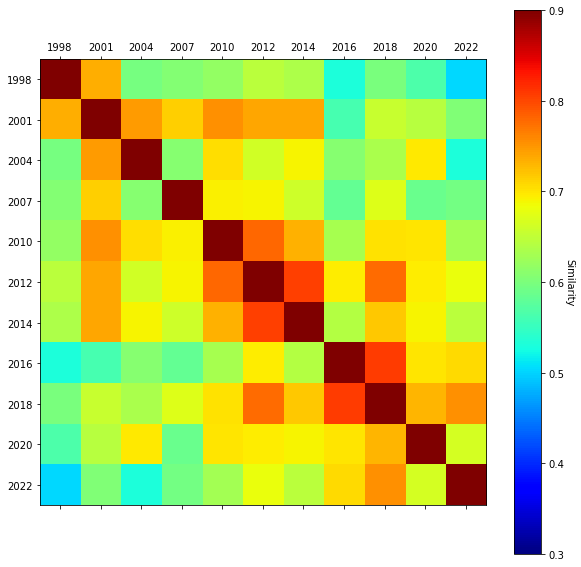

In [51]:
pcs_vs_pcs = HeatMap(pcs_lmks, x_name=lambda a: a['name'], vmax=.9, vmin=.3)
pcs_vs_pcs.compute_similarity()
pcs_vs_pcs.show("pcs_vs_pcs.tex")

What happens if we do the same thing with the authors?

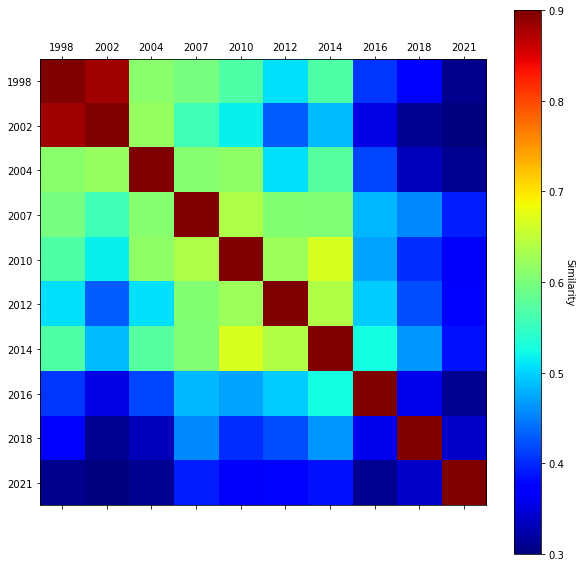

In [35]:
aus_vs_aus = HeatMap(authors_lmks, x_name=lambda a: a['name'], vmax=.9, vmin=.3)
aus_vs_aus.compute_similarity()
aus_vs_aus.show("aus_vs_aus.tex")

The author heatmap is much colder than the pc heatmap. It seems interesting to investigate this by looking at the overlap.

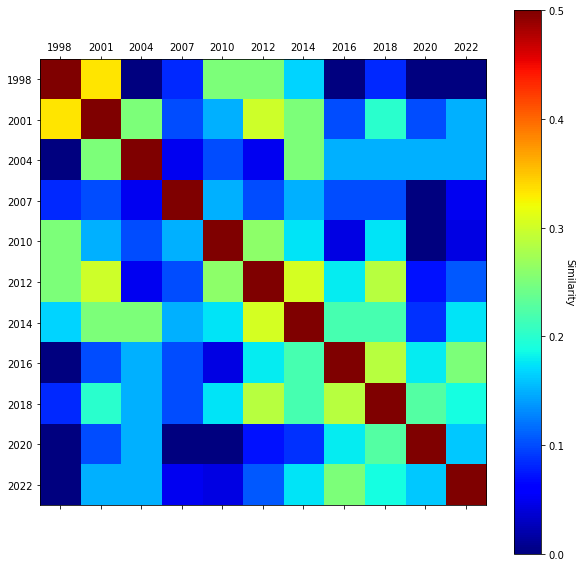

In [31]:
pcs_vs_pcs.compute_overlap()
pcs_vs_pcs.vmin=0
pcs_vs_pcs.vmax=.5
pcs_vs_pcs.show("pcs_vs_pcs_overlap.tex")

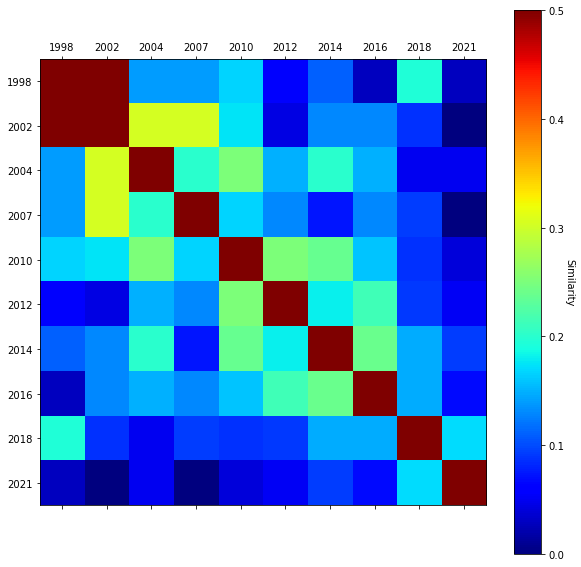

In [33]:
aus_vs_aus.compute_overlap()
aus_vs_aus.vmin=0
aus_vs_aus.vmax=.5
aus_vs_aus.show("aus_vs_aus_overlap.tex")

Interestingly, while the intensity difference that shows on similarity is less obvious when one look at the raw overlaps. That would suggest that all things being equal committes are more stable (in the embedding space) along time that authors.

To be fair, there is another possible explanation of the lesser intensity of similarity between pcs and authors. it may also could come from the average pool size, which is 24 for PCs and 64 for authors. Broadly speaking / all things being equal otherwise, a larger pool means higher "dilution" in the embedding space.

In [36]:
np.mean([len(e['dblp'].split()) for e in authors_source])

65.4

In [37]:
np.mean([len(e['dblp'].split()) for e in pcs_source])

24.454545454545453

Last bu not least, the authors vs PCs heatmap. Lines represent committees, columns represent authors.

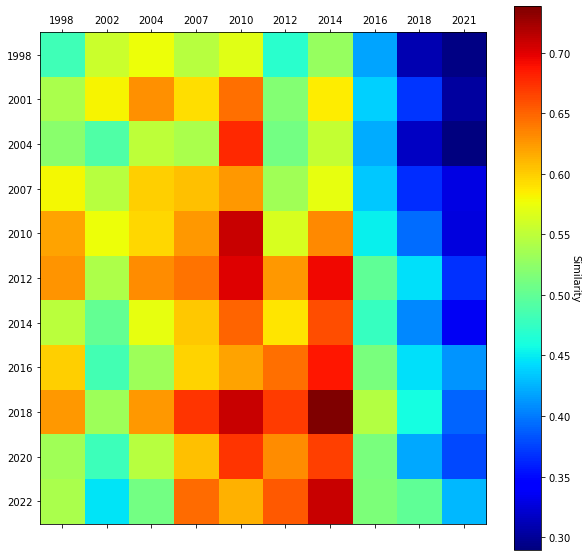

In [39]:
aus_vs_pcs = HeatMap(authors_lmks, y_lmks=pcs_lmks, x_name=lambda a: a['name'], y_name=lambda a: a['name'])
aus_vs_pcs.compute_similarity()
aus_vs_pcs.show("aus_vs_pcs.tex")

Interpretations:
- 2002 (authors) is the more uncorrelated. Possible explanation: second edition tries to find itself? Note that the actual similarity is not that bad (changing vmin/vmax allows to have smoother heatmap, but at least here we have contrast).
- If we look at temporal correlation, the global trend is that the PCs adapts to the authors. This is especially visible after 2012. In other words: the PCs seem to fit the past programs. Higher impact of editions 2010 to 2014.

For FUN: the same comparison using the overlap metric.

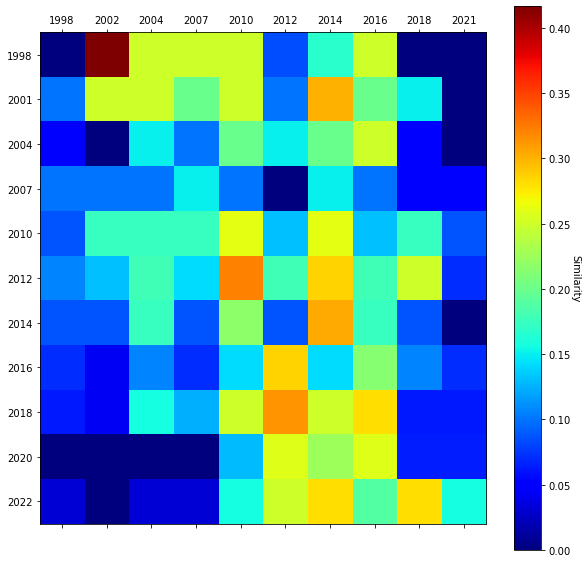

In [40]:
aus_vs_pcs.compute_overlap()
aus_vs_pcs.show("aus_vs_pcs_overlap.tex")

We can see two main trends:
- Early edition (mainly 1998 and 2001): the pioneer PC members became authors afterwards.
- Steady state regime (since 2010): authors in one edition tend to become PC members in later editions.

## Lincs between topics and committes

We can zoom on a set of topics and observe how well it was represented in the program committees. We decided to zoom on 3 sets:
- The official 2022 FUN topics
- The official 2010 FUN topics
- The official 1998 FUN topics

Sadly, NLP is not fun... keeping "FUN with " in the topic description may pollute the results a bit, so we remove the FUN.

In [41]:
def no_fun(program):
    return [e.replace('FUN with ', '') for e in program]

In [42]:
topics_2022 =no_fun([
    'FUN with biological algorithms',
    'FUN with combinatorial algorithms',
    'FUN with cryptographic algorithms',
    'FUN with distributed algorithms',
    'FUN with game-theoretic algorithms',
    'FUN with geometrical algorithms',
    'FUN with graph algorithms',
    'FUN with mobile algorithms',
    'FUN with machine learning algorithms',
    'FUN with optimization algorithms',
    'FUN with parallel algorithms',
    'FUN with randomized algorithms',
    'FUN with robotics algorithms',
    'FUN with space-conscious algorithms',
    'FUN with string algorithms',
    'FUN with visualization of algorithms',
    'FUN with web algorithms',
    'FUN with algorithmic simplicity'
])

In [43]:
topics_2010 = no_fun([
    'FUN with biological algorithms',
    'FUN with combinatorial algorithms',
    'FUN with cryptographic algorithms',
    'FUN with distributed algorithms',
    'FUN with game-theoretic algorithms',
    'FUN with geometrical algorithms',
    'FUN with internet algorithms',
    'FUN with mobile algorithms',
    'FUN with optimization algorithms',
    'FUN with parallel algorithms',
    'FUN with robotics algorithms',
    'FUN with space-conscious algorithms',
    'FUN with string algorithms',
    'FUN with algorithm visualization'
])

In [44]:
topics_1998 = no_fun([
    'FUN with combinatorial',
    'FUN with randomized algorithms',
    'FUN with distributed algorithms',
    'FUN with geometrical algorithms',
    'FUN with parallel algorithms',
    'FUN with numerical algorithms',
])

### 1998

In [45]:
topics_1998_lmks = Landmarks(source=topics_1998)
topics_1998_lmks.fit(xgismo)

We order the topic by similarity with the PC for the year considered.

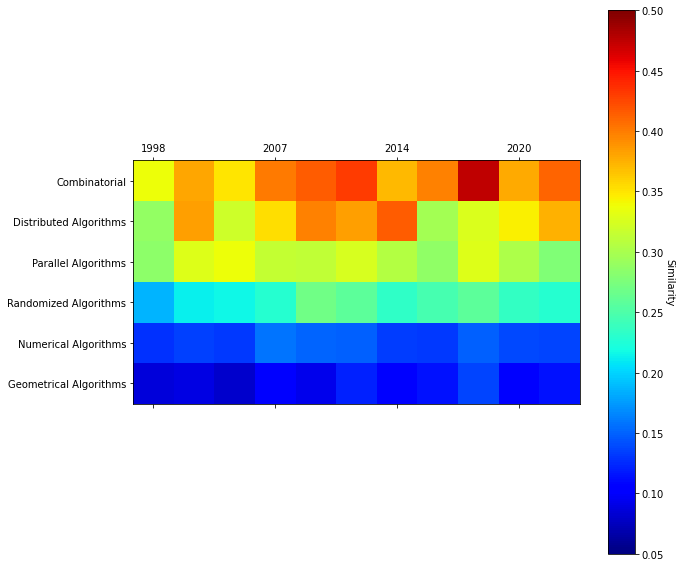

In [65]:
pcs_vs_t98 = HeatMap(pcs_lmks, x_slice=slice(0, 22, 3), x_name=lambda a: a['name'], 
                     y_lmks=topics_1998_lmks, y_name=lambda a: a.title(),
                     vmin=.05, vmax=.5, y_key=lambda s: -s[:, 0])
pcs_vs_t98.compute_similarity()
pcs_vs_t98.show("pcs_vs_t98.tex")

For authors, we also order the topics by similarity with the **PC** for the year considered (this facilitates the comparison between the two heatmaps).

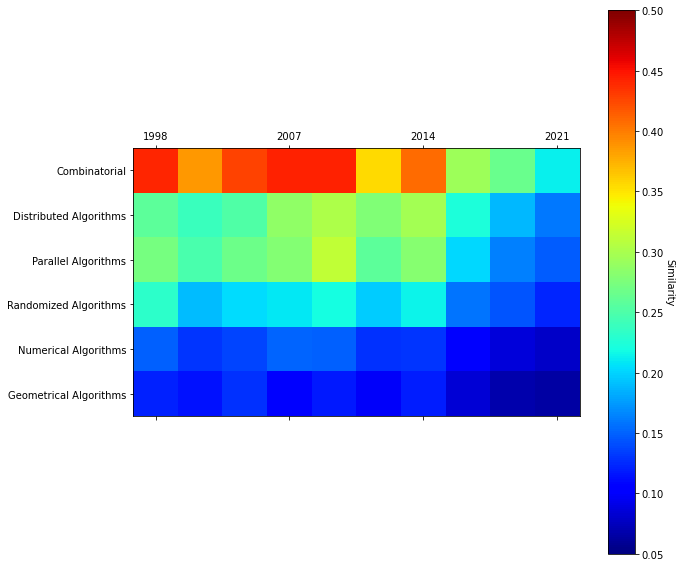

In [66]:
aus_vs_t98 = HeatMap(authors_lmks, x_slice=slice(0, 22, 3), x_name=lambda a: a['name'], 
                     y_lmks=topics_1998_lmks, y_name=lambda x: x.title(),
                     vmin=.05, vmax=.5, y_key=lambda s: -pcs_vs_t98.matrix[:, 0])
aus_vs_t98.compute_similarity()
aus_vs_t98.show("aus_vs_t98.tex")

### 2010

In [67]:
topics_2010_lmks = Landmarks(source=topics_2010)
topics_2010_lmks.fit(xgismo)

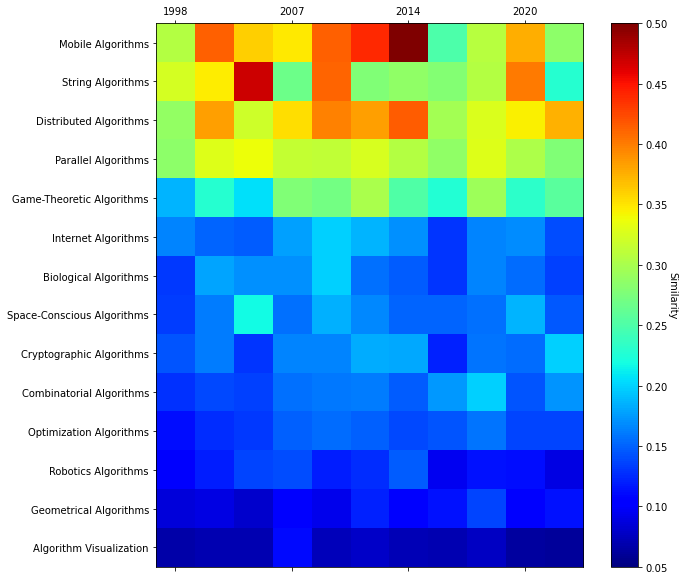

In [68]:
pcs_vs_t10 = HeatMap(pcs_lmks, x_slice=slice(0, 22, 3), x_name=lambda a: a['name'], 
                     y_lmks=topics_2010_lmks, y_name=lambda x: x.title(),
             vmin=.05, vmax=.5, y_key=lambda s: -s[:, 4])
pcs_vs_t10.compute_similarity()
pcs_vs_t10.show("pcs_vs_t10.tex")

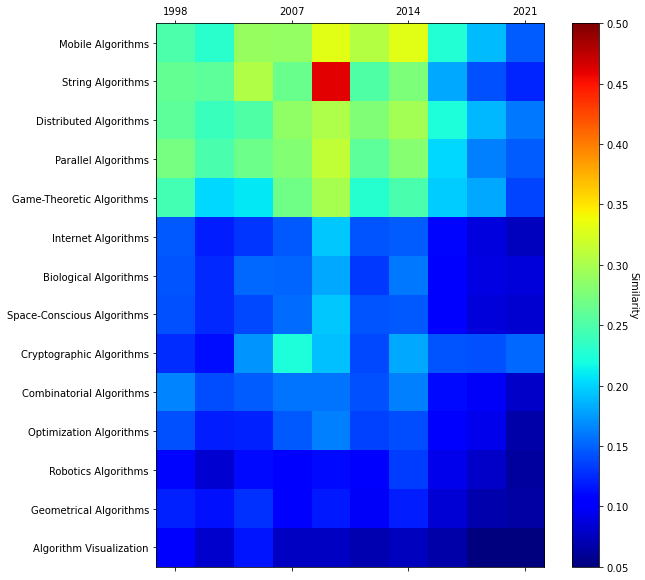

In [69]:
aus_vs_t10 = HeatMap(authors_lmks, x_slice=slice(0, 22, 3), x_name=lambda a: a['name'], 
                     y_lmks=topics_2010_lmks, y_name=lambda x: x.title(),
             vmin=.05, vmax=.5, y_key=lambda s: -pcs_vs_t10.matrix[:, 4])
aus_vs_t10.compute_similarity()
aus_vs_t10.show("aus_vs_t10.tex")

### 2022

In [70]:
topics_2022_lmks = Landmarks(source=topics_2022)
topics_2022_lmks.fit(xgismo)

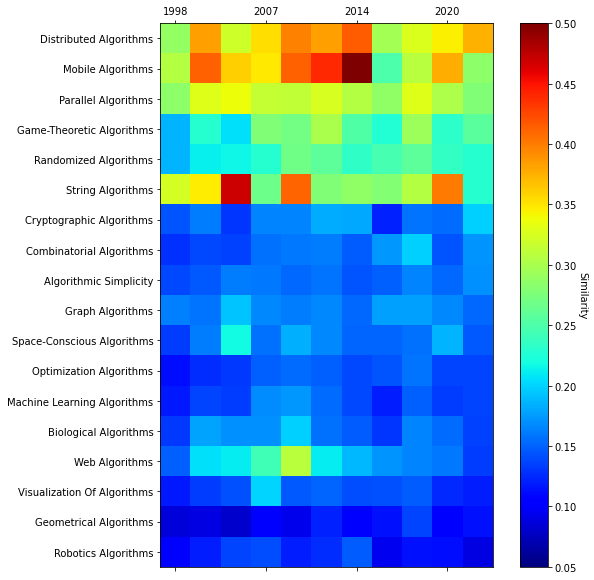

In [71]:
pcs_vs_t22 = HeatMap(pcs_lmks, x_slice=slice(0, 22, 3), x_name=lambda a: a['name'], 
                     y_lmks=topics_2022_lmks, y_name=lambda x: x.title(),
             vmin=.05, vmax=.5, y_key=lambda s: -s[:, 10])
pcs_vs_t22.compute_similarity()
pcs_vs_t22.show("pcs_vs_t22.tex")

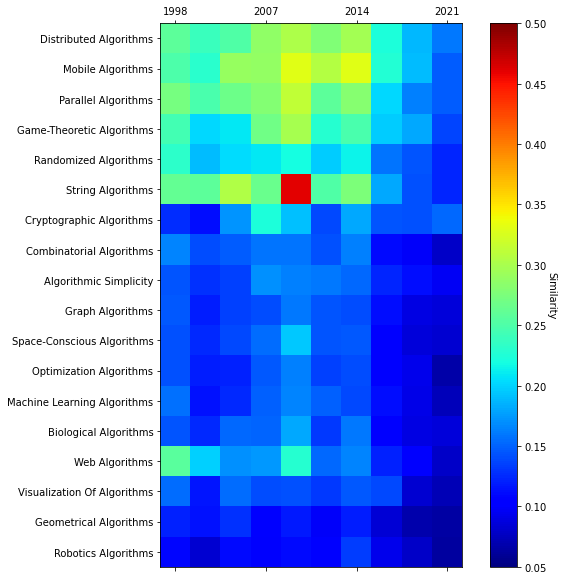

In [72]:
aus_vs_t22 = HeatMap(authors_lmks, x_slice=slice(0, 22, 3), x_name=lambda a: a['name'], 
                     y_lmks=topics_2022_lmks, y_name=lambda x: x.title(),
             vmin=.05, vmax=.5, y_key=lambda s: -pcs_vs_t22.matrix[:, 10])
aus_vs_t22.compute_similarity()
aus_vs_t22.show("aus_vs_t22.tex")

## instant committee recommendation

To demonstrate a small but useful feature of Gismo, we propose a function to help deciding members of a program committee with respect to a new field.

In [73]:
fun_pc_members = {a for y in pcs_lmks for a in y['dblp'].split()}

def spacify(name):
    return name.replace("_", " ")

def new_pc_proposal(query, k=10, overlap=None):
    """
    Propose a selection of researchers to cover a topic.
    
    Parameters
    ----------
    query: str
        The topic that we want to cover.
    k: int, optional
        Number of researchers that will be proposed (default to 10).
    overlap: float, optional
        If set, about overlap % of returned researchers will be members of previous committees.
        If not, the k more relevant researchers will be returned regardless of their previous memberships.
        
    Returns
    -------
    dict
        Dictionary with two entries, one for former committee members, one for new members. 
        For each member, the name and rank (a.k.a relevance to the query, rank is NOT an indication of value) is returned.
    """
    success = xgismo.rank(query)
    if not success:
        print("Request not found")
        return False
    
    print(f"Looking for researchers involved in: {', '.join(xgismo.get_features_by_rank())}")

    if overlap is None:
        is_former = [xgismo.corpus[n] in fun_pc_members for n in xgismo.diteration.x_order[:k]]
        inside_indices = [i for i, former in enumerate(is_former) if former]
        outside_indices = [i for i, former in enumerate(is_former) if not former]
    else:    
        is_former = [xgismo.corpus[n] in fun_pc_members for n in xgismo.diteration.x_order]
        k_inside = int(overlap * k /100)
        k_outside = k - k_inside
        inside_indices = [i for i, former in enumerate(is_former) if former][:k_inside]
        outside_indices = [i for i, former in enumerate(is_former) if not former][:k_outside]
    
    return {
        'Suggestion of former members': [{'name': spacify(xgismo.corpus[xgismo.diteration.x_order[i]]), 'rank': i} 
                                           for i in inside_indices],
        'Suggestion of new members': [{'name': spacify(xgismo.corpus[xgismo.diteration.x_order[i]]), 'rank': i} 
                                           for i in outside_indices]

    }    

Example: finding PC members for quantum networks.

In [74]:
new_pc_proposal('quantum computing')

Looking for researchers involved in: quantum, computing, quantum computing, classical, quantum computation, bqp, computation, qubit, blind quantum, power, polynomial, blind, supremacy, communication, clean, proof, computational, automata


{'Suggestion of former members': [{'name': 'Harumichi Nishimura', 'rank': 3}],
 'Suggestion of new members': [{'name': 'Tomoyuki Morimae', 'rank': 0},
  {'name': 'Scott Aaronson', 'rank': 1},
  {'name': 'Aram W. Harrow', 'rank': 2},
  {'name': 'Ke Yang', 'rank': 4},
  {'name': 'Daniel Gottesman', 'rank': 5},
  {'name': 'Mark Zhandry', 'rank': 6},
  {'name': 'Abuzer Yakaryilmaz', 'rank': 7},
  {'name': 'Seiichiro Tani', 'rank': 8},
  {'name': 'Tomoyuki Yamakami', 'rank': 9}]}

Enforce a proportion of 50% of former PC members in the results (we will keep that parameter in the rest of this notebook).

In [75]:
new_pc_proposal('quantum computing', overlap=50)

Looking for researchers involved in: quantum, computing, quantum computing, classical, quantum computation, bqp, computation, qubit, blind quantum, power, polynomial, blind, supremacy, communication, clean, proof, computational, automata


{'Suggestion of former members': [{'name': 'Harumichi Nishimura', 'rank': 3},
  {'name': 'Sergio Rajsbaum', 'rank': 75},
  {'name': 'Arnold L. Rosenberg', 'rank': 91},
  {'name': 'Nicola Santoro', 'rank': 94},
  {'name': 'Kurt Mehlhorn', 'rank': 104}],
 'Suggestion of new members': [{'name': 'Tomoyuki Morimae', 'rank': 0},
  {'name': 'Scott Aaronson', 'rank': 1},
  {'name': 'Aram W. Harrow', 'rank': 2},
  {'name': 'Ke Yang', 'rank': 4},
  {'name': 'Daniel Gottesman', 'rank': 5}]}

Find suggestions for enforcing the board games topic.

In [76]:
new_pc_proposal('board games', overlap=50)

Looking for researchers involved in: board, game, interlock, corporate, games, board interlock, voting, robot, reliability, networks, approach, small, flood, evolving, swarm, test, league, map generation


{'Suggestion of former members': [{'name': 'Jean-Claude Bermond', 'rank': 10},
  {'name': 'Jürg Nievergelt', 'rank': 30},
  {'name': 'Marc J. van Kreveld', 'rank': 55},
  {'name': 'Steven Skiena', 'rank': 60},
  {'name': 'Erik D. Demaine', 'rank': 121}],
 'Suggestion of new members': [{'name': 'Frank W. Takes', 'rank': 0},
  {'name': 'Alexander Scott 0001', 'rank': 1},
  {'name': 'Javier Garcia-Bernardo', 'rank': 2},
  {'name': 'Koki Suetsugu', 'rank': 3},
  {'name': 'Kitty Meeks', 'rank': 4}]}

What about formal methods?

In [77]:
new_pc_proposal('formal methods', overlap=50)

Looking for researchers involved in: formal, formal method, method, preface, embedded software, magic, power, touch, software, molecular biology, embedded, security, verification, biology, systems, molecular, meter, specification, tools, language, introduction


{'Suggestion of former members': [{'name': 'Sandy Irani', 'rank': 27},
  {'name': 'Marcella Anselmo', 'rank': 89},
  {'name': 'José D. P. Rolim', 'rank': 94},
  {'name': 'Antonio Restivo', 'rank': 136},
  {'name': 'Tandy J. Warnow', 'rank': 166}],
 'Suggestion of new members': [{'name': 'Andrzej Tarlecki', 'rank': 0},
  {'name': 'Donald Sannella', 'rank': 1},
  {'name': 'Didier Bégay', 'rank': 2},
  {'name': 'Jean-Pierre Radoux', 'rank': 3},
  {'name': 'Matteo Maffei', 'rank': 4}]}

One last for the road.

In [79]:
new_pc_proposal('self-stabilization', overlap=50)

Looking for researchers involved in: self, stabilization, stabilize, self stabilization, self stabilize, byzantine, distribute, stabilizing, networks, distributed, mobile, snap, systems, asynchronous, fault, routing, brief


{'Suggestion of former members': [{'name': 'Shlomi Dolev', 'rank': 1},
  {'name': 'Shay Kutten', 'rank': 3},
  {'name': 'Boaz Patt-Shamir', 'rank': 18},
  {'name': 'Paolo Boldi', 'rank': 70},
  {'name': 'Sebastiano Vigna', 'rank': 71}],
 'Suggestion of new members': [{'name': 'Sébastien Tixeuil', 'rank': 0},
  {'name': 'Toshimitsu Masuzawa', 'rank': 2},
  {'name': 'Stéphane Devismes', 'rank': 4},
  {'name': 'Swan Dubois', 'rank': 5},
  {'name': 'Karine Altisen', 'rank': 6}]}